pelvis - DTW
     L0        L1        L2
0   0.0 -0.185052  0.243747
1   0.0  0.063186  0.087844
2   0.0  0.125805   0.26585
3   0.0 -0.013787  0.057441
4   0.0  0.168102  0.457245
5   0.0 -0.173374 -0.172958
6   0.0 -0.130453  -0.21163
7   0.0  0.094802  0.146287
8   0.0  0.207853  0.722446
9   0.0  0.106406  0.358532
10  0.0  0.397455   1.67521
pelvis - MDP
     L0        L1        L2
0   0.0 -0.016167  0.043872
1   0.0  0.005895   0.00501
2   0.0  0.016606  0.026316
3   0.0  0.015272  0.011593
4   0.0  0.039748  0.077032
5   0.0 -0.009207 -0.014103
6   0.0 -0.004886 -0.019444
7   0.0  0.009166  0.017931
8   0.0  0.037321  0.093613
9   0.0  0.010485  0.041639
10  0.0  0.052072  0.215191
pelvis - HMM-SM
     L0        L1        L2
0   0.0 -0.015754 -0.016204
1   0.0  0.058059  0.035822
2   0.0 -0.026292  0.057954
3   0.0  0.028039 -0.086524
4   0.0  0.001086  0.007503
5   0.0 -0.047654  0.053664
6   0.0 -0.065071 -0.086579
7   0.0 -0.006747  0.042458
8   0.0 -0.009487 -0.147719
9   0.

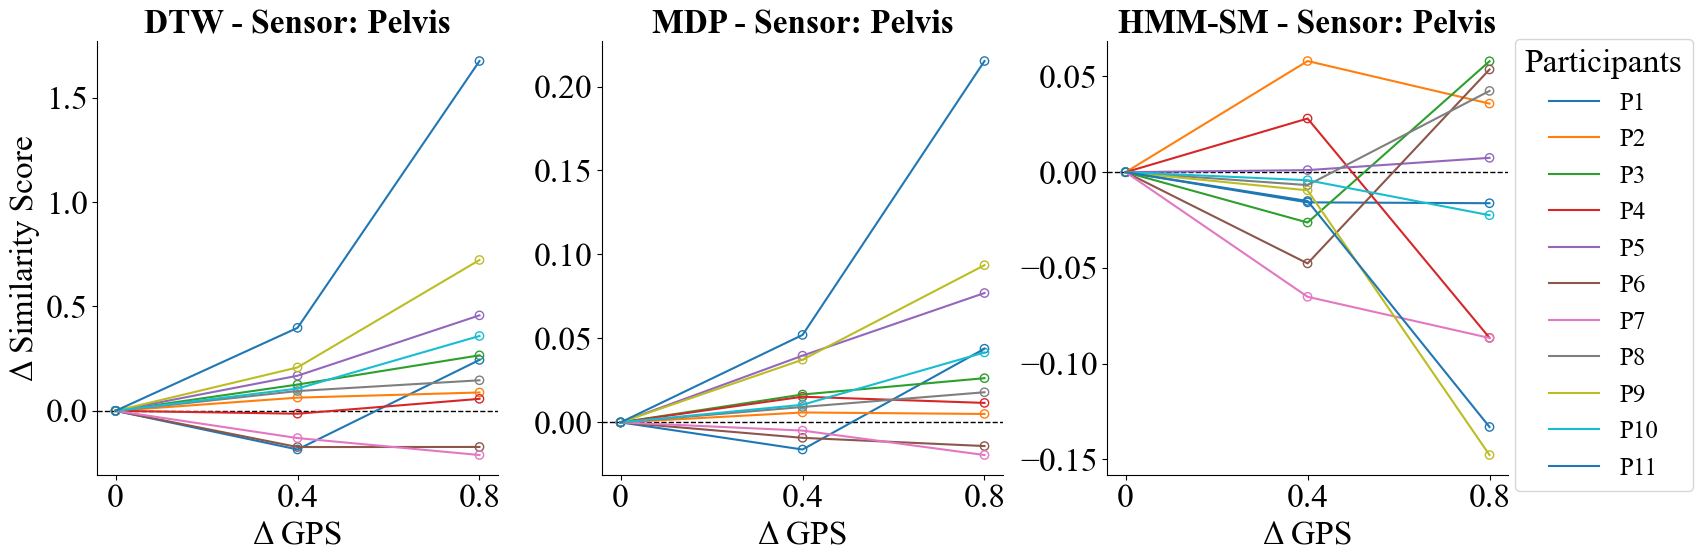

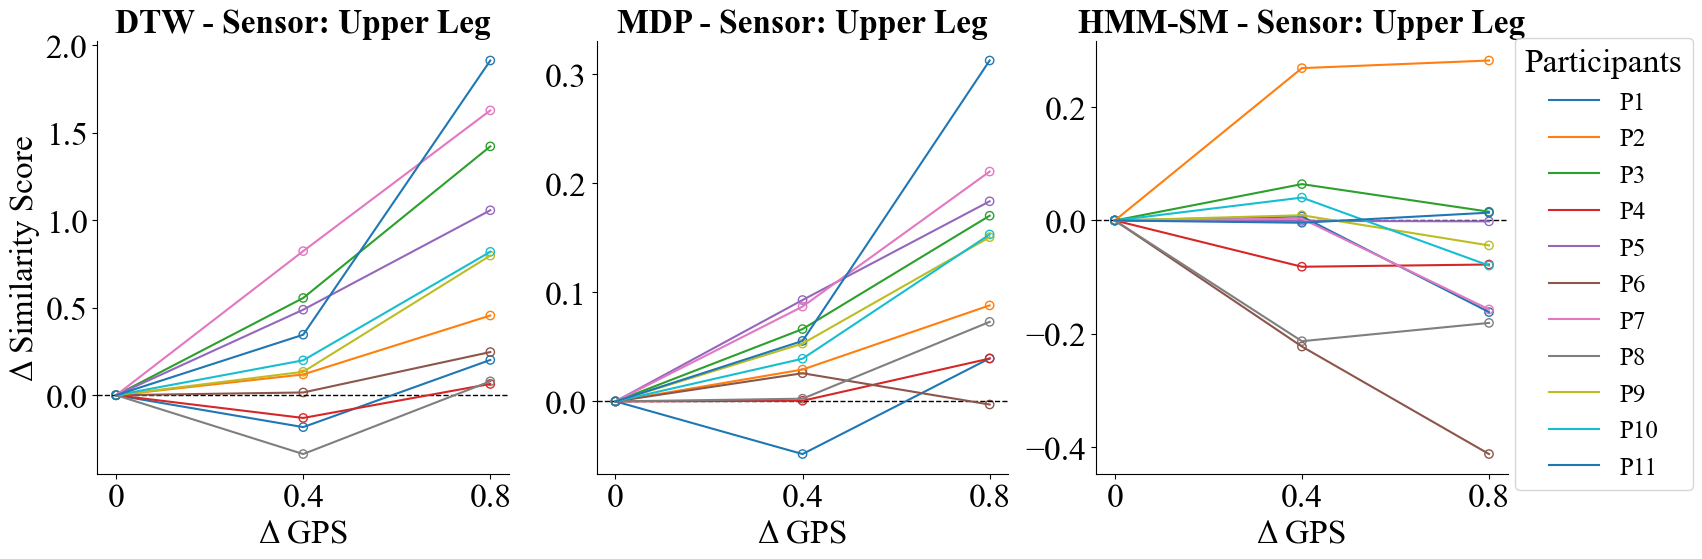

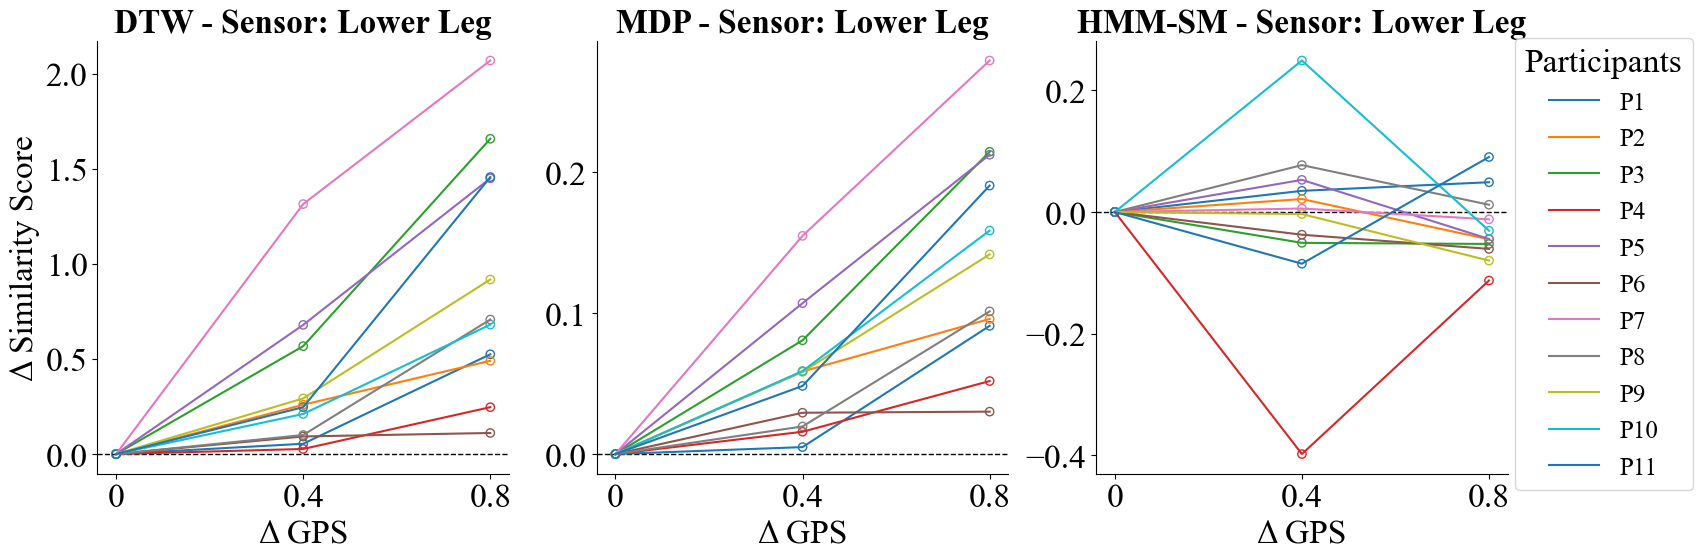

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

""" Generates the scatter and line plots used for GPS and STSR partitioning in the LLA RAS Study"""

# Read the data
file_path = fr"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\LLA RAS PT Manuscript\Results\RAS Group\STSR Results\STSR_Eval_logresults_23-08-24_22-42.csv"
data = pd.read_csv(file_path)
data.columns = ['FilePath', 'Sensor', 'GaitParam', 'Algorithm', 'Participant', 'X', 'Y']
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')

# Function to plot scatter plots
def plot_scatter(data, sensor, gait_param = 'STSR'):
    
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = "Times New Roman"

    sensor_titles = {'upper': 'Upper Leg', 'lower': 'Lower Leg', 'pelvis': 'Pelvis'} 
    algorithms = list(data['Algorithm'].unique())
    
    if gait_param == 'GPS':
        x_levels = ['0', '0.4', '0.8']
    elif gait_param == 'STSR':
        x_levels = ['0', '0.03', '0.06']
    
    #Makes sure it is the last one 
    if "HMM-SM" in algorithms:
        algorithms.remove("HMM-SM")
        algorithms.append("HMM-SM")
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure for subplots
    
    for idx, algorithm in enumerate(algorithms):
        subset = data[(data['Algorithm'] == algorithm) & (data['Sensor'] == sensor)]
        df = pd.DataFrame(columns=['L0', 'L1', 'L2'], index=range(len(subset['Participant'].unique())))
        df_ydiff = pd.DataFrame(columns=['L0', 'L1', 'L2'], index=range(len(subset['Participant'].unique())))
        
        colorslist = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors = [colorslist[i % len(colorslist)] for i in range(len(subset['Participant'].unique()))]
    
        if not subset.empty:
            ax = axs[idx]
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.axhline(y=0,linestyle='--',linewidth=1,color='k')
            for i, participant in enumerate(subset['Participant'].unique()):
                participant_data = subset[subset['Participant'] == participant].copy()
                if algorithm == "HMM-SM":
                    participant_data = participant_data.iloc[1:]  # Remove the first entry for HMM-SM
                Y = participant_data['Y']
                participant_data['Y_diff'] = participant_data['Y'] - participant_data['Y'].iloc[0]
                Y_diff = participant_data['Y_diff'].values.tolist()
                df.loc[i] = Y
                
                df_ydiff.loc[i] = Y_diff
                ax.plot(x_levels, Y_diff, label=f"P{i+1}")
                ax.scatter(x_levels, Y_diff, marker='o', edgecolors=colors[i], facecolors='none')
                
            ax.set_xlabel(f"Δ {gait_param}", fontsize=24)
            ax.tick_params(axis='both', which='major', labelsize=24)
            
            if idx == 0:
                ax.set_ylabel("Δ Similarity Score", fontsize=24)  # Only on the leftmost plot
            ax.set_title(f"{algorithm} - Sensor: {sensor_titles[sensor]}", fontsize=24, fontweight='bold')
            print(f"{sensor} - {algorithm}")
            print(df_ydiff)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.95, 0.5), title="Participants", fontsize=18, title_fontsize=24)
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust rect to leave space for the title and legend
    
    sensor_titles = {'upper': 'Upper Leg', 'lower': 'Lower Leg', 'pelvis': 'Pelvis'}
    directory, filename = os.path.split(file_path)
    basename, ext = os.path.splitext(filename)
    image_filename = f"{basename}_{sensor}.svg"
    image_file_path = os.path.join(directory, image_filename)
    #plt.savefig(image_file_path)
 
sensors = data['Sensor'].unique()
Algorithms = data['Algorithm'].unique()

# Plot for each sensor across all algorithms
for sensor in sensors:
    plot_scatter(data, sensor)

In [6]:
""" T-test, benjamini-hochberg correction and SRM for each comparison level - Can be used for either the RAS or PT data"""

import numpy as np
import pandas as pd
import pingouin as pg
import os
from itertools import combinations


file_path = r"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\LLA RAS PT Manuscript\Results\PT Group\PT Results\PT_Eval_logresults_23-08-24_18-06.csv"
data = pd.read_csv(file_path)
data.columns = ['FilePath', 'Sensor', 'GaitParam', 'Algorithm', 'Participant', 'X', 'Y']
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')
data['X'] = pd.to_numeric(data['X'], errors='coerce')


## Specify either RAS or PT for the function -- will determine which levels it creates in the dataframe 

def analysis_byalgorithm(data, algorithm, sensor, parametric=True, correction='fdr_bh',trial_type='PT'):
    
    subset = data[(data['Algorithm'] == algorithm) & (data['Sensor'] == sensor)]
    print(f'Generating results for {algorithm}, {sensor}, number of data points: {len(subset)}')
    
    if trial_type == "PT":
        levels = ['Pre-Rehab','Post-Rehab']
    elif trial_type == "RAS":
        levels = ['L0','L1','L2']
    else:
        ValueError("Invalid trial type")
        
    df = pd.DataFrame(columns=levels, index=range(len(data['Participant'].unique())))  # Initialize outside the loop
    
    if not subset.empty:
        for i, participant in enumerate(subset['Participant'].unique()):
            participant_data = subset[subset['Participant'] == participant].copy()
            if algorithm == "HMM-SM":
                participant_data = participant_data.iloc[1:]  # Remove the first entry for HMM-SM
            Y = participant_data['Y'].values.tolist()
            df.loc[i] = Y

    df.dropna(inplace=True)

    #Formats the data appropriately so that can use pingouin stats library 
    df_melted = df.reset_index().melt(id_vars=['index'], var_name='Level', value_name='Y')
    df_melted.rename(columns={'index': 'Participant'}, inplace=True)
    df_melted['Y'] = pd.to_numeric(df_melted['Y'], errors='coerce')
    df_melted.dropna(subset=['Y'], inplace=True)

    results = pg.pairwise_tests(
        dv='Y', 
        within='Level', 
        subject='Participant', 
        data=df_melted, 
        parametric=parametric, 
        padjust=correction, 
        effsize='cohen'
    )

    # Calculate SRM for each comparison
    srm_values = {}
    normality = {}
    pairs = list(combinations(levels, 2))
    
    for level1, level2 in pairs:
        
        data1 = df[df.columns[df.columns.get_loc(level1)]].astype(float)
        data2 = df[df.columns[df.columns.get_loc(level2)]].astype(float)
        
        if not data1.empty and not data2.empty:
            
            ## SRM Calculation 
            difference = data1 - data2
            mean_diff = np.mean(difference)
            std_diff = np.std(difference, ddof=1)
            srm =  mean_diff / std_diff if std_diff != 0 else np.nan
            srm_values[f'{level1}_vs_{level2}'] = srm
            
            ## Determines normality of differences between pairs (used to assess whether parametric or non-parametric tests are appropriate)
            normality_res = pg.normality(difference)
            p_normality = normality_res['pval'].values[0]
            normality_value = True if p_normality > 0.05 else p_normality
            normality[f'{level1}_vs_{level2}'] = normality_value
        
        else:
            print(f"Data for {level1} or {level2} is empty.")
            srm_values[f'{level1}_vs_{level2}'] = np.nan

    results['Sensor'] = sensor
    results['Algorithm'] = algorithm
    
    if len(pairs) == 1: #Pre/Post PT 
        
        # Directly assign the SRM and Normality if there is only one comparison pair
        comparison_key = f'{pairs[0][0]}_vs_{pairs[0][1]}'
        results['SRM'] = srm_values.get(comparison_key, np.nan)
        results['Normality'] = normality.get(comparison_key, np.nan)
    else:
        #apply for multiple comparison pairs
        results['SRM'] = results.apply(lambda row: srm_values.get(f'{row["A"]}_vs_{row["B"]}', np.nan), axis=1)
        results['Normality'] = results.apply(lambda row: normality.get(f'{row["A"]}_vs_{row["B"]}', np.nan), axis=1)

    # Reorder columns to make 'Sensor' and 'Algorithm' the leftmost columns
    results = results[['Sensor', 'Algorithm'] + [col for col in results.columns if col not in ['Sensor', 'Algorithm']]]

    directory, filename = os.path.split(file_path)
    basename, ext = os.path.splitext(filename)
    new_filename = f"{basename}_statistics{ext}"

    output_file_path = os.path.join(directory, new_filename)
    if not os.path.exists(output_file_path):
        results.to_csv(output_file_path, index=False)
    else:
        results.to_csv(output_file_path, mode='a', header=False, index=False)

    print(f"Results appended to {output_file_path}")



# Get unique combinations of sensors and algorithms
sensors = data['Sensor'].unique()
algorithms = data['Algorithm'].unique()

# Perform analysis for each combination of sensor and algorithm
for sensor in sensors:
    for algorithm in algorithms:
        analysis_byalgorithm(data, algorithm, sensor, parametric=False, correction='fdr_bh',trial_type='PT')  

Generating results for DTW, pelvis, number of data points: 24
Results appended to Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\LLA RAS PT Manuscript\Results\PT Group\PT Results\PT_Eval_logresults_23-08-24_18-06_statistics.csv
Generating results for MDP, pelvis, number of data points: 24
Results appended to Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\LLA RAS PT Manuscript\Results\PT Group\PT Results\PT_Eval_logresults_23-08-24_18-06_statistics.csv
Generating results for HMM-SM, pelvis, number of data points: 36
Results appended to Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\LLA RAS PT Manuscript\Results\PT Group\PT Results\PT_Eval_logresults_23-08-24_18-06_statistics.csv
Generating results for DTW, Upper, number of data points: 24
Results appended to Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\LLA RAS PT Manuscript\Results\PT Group\PT Results\PT_Eval_logresults_23-08-24_18-06_statistics.csv
Generating results for MDP, Upper, number of data points: 24
R

In [ ]:
import numpy as np
import pandas as pd
import pingouin as pg
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from csv import writer

""" Script for applying regressions to change in GPS (absolute) vs. change in similarity score from the PT trials"""

file_path = r"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\LLA RAS PT Manuscript\Results\PT Group\PT Results\PT_Eval_logresults_23-08-24_18-06.csv" #Insert relevant file path here 
directory, filename = os.path.split(file_path)
basename, ext = os.path.splitext(filename)
data = pd.read_csv(file_path)
data.columns = ['FilePath', 'Sensor', 'GaitParam', 'Algorithm', 'Participant', 'X', 'Y']
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')


def plot_regressions(data, algorithms, sensor):
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = "Times New Roman"
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  
    for idx, algorithm in enumerate(algorithms):
        subset = data[(data['Algorithm'] == algorithm) & (data['Sensor'] == sensor)]
        print(f'Generating results for {algorithm}, {sensor}, number of data points: {len(subset)}')

        df = pd.DataFrame(columns=['Pre-Rehab','Post-Rehab'], index=range(len(data['Participant'].unique())))  # Initialize outside the loop
        df_difference = pd.DataFrame(columns=['Δ GPS','Δ Similarity'], index=range(len(data['Participant'].unique())))
        
        if not subset.empty:
            for i, participant in enumerate(subset['Participant'].unique()):
                participant_data = subset[subset['Participant'] == participant].copy()
                if algorithm == "HMM-SM":
                    participant_data = participant_data.iloc[1:]  # Remove the first entry for HMM-SM (this is because it also reports the within reference group similarity, and we didn't look at that)
                    participant_data['X'] = participant_data['X'].apply(lambda x: float(x.split('-')[1].strip()) if isinstance(x, str) else x)
                    
                participant_data['X'] = pd.to_numeric(participant_data['X'], errors='coerce')
                participant_data['Y_diff'] =  participant_data['Y'].iloc[1] -  participant_data['Y'].iloc[0]
                participant_data['X_diff'] =  participant_data['X'].iloc[1] - participant_data['X'].iloc[0]
                participant_data['X_diff'] = participant_data['X_diff'].abs()
                
                df_difference.at[i, 'Δ GPS'] = participant_data['X_diff'].iloc[0]
                df_difference.at[i, 'Δ Similarity'] = participant_data['Y_diff'].iloc[0]
                df_difference['Δ GPS'] = pd.to_numeric(df_difference['Δ GPS'], errors='coerce')
                df_difference['Δ Similarity'] = pd.to_numeric(df_difference['Δ Similarity'], errors='coerce')
        
        ax = axs[idx]
        ax.tick_params(axis='both', which='major', labelsize=18)
        
        sensor_titles = {'Upper': 'Upper Leg', 'Lower': 'Lower Leg', 'pelvis': 'Pelvis'}
        sns.regplot(data=df_difference, x=df_difference['Δ GPS'], y=df_difference['Δ Similarity'],ci=None,color='black',scatter_kws={'s': 30, 'facecolor': 'None', 'linewidths': 2}, ax= ax).set_title(f"{algorithm} - Sensor: {sensor_titles[sensor]}",fontweight='bold',fontsize=24)
        if idx == 0:
            ax.set_ylabel('Δ Similarity', fontsize=18)
        else:
            ax.set_ylabel('')
        # Set the x-axis label only for the bottom plot (last plot in the row)
        if idx == 1:
            ax.set_xlabel('Δ GPS', fontsize=18)
        else:
            ax.set_xlabel('')
        ax.xaxis.label.set_size(24)
        ax.yaxis.label.set_size(24)
        r_value, p_value = pearsonr(df_difference['Δ GPS'], df_difference['Δ Similarity'])
        d = {'sensor': sensor, 'algorithm':algorithm, 'r-value': r_value, 'p_value': p_value}
        results_df = pd.DataFrame(data=d, index=[0])
        ax.text(0.95, 0.95, f'Pearson r = {r_value:.2f}\n(p = {p_value:.3f})',
                transform=ax.transAxes,
                fontsize=24,
                verticalalignment='top',horizontalalignment='right')
        
        directory, filename = os.path.split(file_path)
        basename, ext = os.path.splitext(filename)
        image_filename = f"{basename}_{sensor}.svg"
        image_file_path = os.path.join(directory, image_filename)
        plt.tight_layout()
        # fig.savefig(image_file_path)
        
        directory, filename = os.path.split(file_path)
        basename, ext = os.path.splitext(filename)
        new_filename = f"{basename}_pearsonr{ext}"
        output_file_path = os.path.join(directory, new_filename)

    # if not os.path.exists(output_file_path):
    #     results_df.to_csv(output_file_path, index=False)
    # else:
    #     results_df.to_csv(output_file_path, mode='a', header=False, index=False)

sensors = data['Sensor'].unique()
algorithms = data['Algorithm'].unique()

for sensor in sensors:
    plot_regressions(data, algorithms, sensor)  # Set parametric to True or False as needed

In [ ]:
import pandas as pd
import pingouin as pg

""" Performing paired t-tests on the Pre/Post trials to evaluate changes in GVS """


# Read the CSV file into a DataFrame
file_path = r"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\RAS_PrePostGVS.csv"
df = pd.read_csv(file_path)

# List of parameters
parameters = [
    'pelvic_tilt',
    'pelvic_obliquity',
    'pelvic_rotation',
    'hip_flexion_L',
    'hip_abduction_L',
    'hip_rotation_L',
    'hip_flexion_R',
    'hip_abduction_R',
    'hip_rotation_R',
    'knee_flexion_R',
    'knee_flexion_L',
    'ankle_flexion_R',
    'ankle_flexion_L',
    'foot_progression_R',
    'foot_progression_L'
]

results = {'Participant': []}
for param in parameters:
    results[param] = []

# Iterate through each participant
for participant in df['Participant'].unique():
    participant_data = df[df['Participant'] == participant]
    results['Participant'].append(participant)
    # Perform paired t-tests for each parameter
    for param in parameters:
        pre_data = participant_data[participant_data['Condition'] == 'Pre'][param]
        post_data = participant_data[participant_data['Condition'] == 'Post'][param]
        if len(pre_data) == len(post_data):
            # Perform the paired t-test
            print(len(pre_data))
            t_test_result = pg.ttest(pre_data, post_data, paired=True)
            results[param].append(t_test_result['p-val'].values[0])
        else:
            results[param].append(None)  

results_df = pd.DataFrame(results)
# output_path = r"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\ttest_RAS_GVS.csv"
# results_df.to_csv(output_path, index=False)
print(results_df)